This notebook shows how to use LLM-Geo, you can uncomment a study case (preferred Case 1 and Case 3) to get the spatial analysis results without any human intervention. 

Please check the [webpage of LLM-Geo](https://github.com/gladcolor/LLM-Geo) for more detail!


#  Install package

In [26]:
# ! pip install pyvis
# ! pip install networkx
# ! pip install openai
# ! pip install requests
# ! pip install pandas
# ! pip install geopandas

# Import package

In [27]:
import os
import requests
import networkx as nx
import pandas as pd
import geopandas as gpd
from pyvis.network import Network
from openai import OpenAI
from IPython.display import display, HTML, Code
from IPython.display import clear_output

# Define Solution class
Please run the following cell to define the functions

In [28]:
%load_ext autoreload
%autoreload 2
import helper
import LLM_Geo_Constants as constants
from LLM_Geo_kernel import Solution



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Demonstration Cases

## Input task and data desciption

In [29]:
isReview = True

In [30]:

# Case 1: population living near hazardous wastes

task_name ='Resident_at_risk_counting'
TASK = r"""1) Find out Census tracts that contain hazardous waste facilities, then comppute and print out the population living in those tracts. The study area is North Carolina (NC), US.
2) Generate a population choropleth map for all tract polygons in NC, rendering the color by tract population; and then highlight the borders of tracts that have hazardous waste facilities. Please draw all polygons, not only the highlighted ones. The map size is 15*10 inches.
"""

DATA_LOCATIONS = ["NC hazardous waste facility ESRI shape file: https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/HW_Sites_EPSG4326.zip.",
                  "NC tract boundary shapefile: https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/tract_37_EPSG4326.zip. The tract ID column is 'GEOID', data types is integer.",
                  "NC tract population CSV file: https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/NC_tract_population.csv. The population is stored in 'TotalPopulation' column. The tract ID column is 'GEOID', data types is integer."
                 ]
 


# # Case 3: COVID-19 death rate in US
# task_name ='COVID_death_rate'
# TASK = r'''1) Draw a choropleth map to show the death rate (death/case) of COVID-19 among the countiguous US counties. Use the accumulated COVID-19 data of 2020.12.31 to compute the death rate. Use scheme ='quantiles' when plotting the map.  Set map projection to 'Conus Albers'. Set map size to 15*10 inches.  
# 2) Draw a scatter plot to show the correlation and trend line of the death rate with the senior resident rate, including the r-square and p-value. Set data point transparency to 50%, regression line as red. Set figure size to 15*10 inches.  
# '''


# DATA_LOCATIONS = [
#                   r"COVID-19 data case in 2020 (county-level): https://github.com/nytimes/covid-19-data/raw/master/us-counties-2020.csv. This data is for daily accumulated COVID cases and deaths for each county in the US. There are 5 columns: date (format: 2021-02-01), county, state, fips, cases, deaths. ",   
#                   r"Contiguous US county boundary (ESRI shapefile): https://github.com/gladcolor/spatial_data/raw/master/contiguous_counties.zip. The county FIPS column is 'GEOID'; map projection is EPSG:4269",
#                   r"Census data (ACS2020): https://raw.githubusercontent.com/gladcolor/spatial_data/master/Demography/ACS2020_5year_county.csv. THe needed columns are: 'FIPS', 'Total Population', 'Total Population: 65 to 74 Years', 'Total Population: 75 to 84 Years', 'Total Population: 85 Years and Over'. Drop rows with NaN cells after loading the used columns.",
#                  ]



# # Case 4: Hospital_accessibility
# task_name ='Hospital_accessibility'
# TASK = r'''
# For each zipcode area in South Carolina (SC), calculate the distance from the centroid of the zipcode area to its nearest hospital, and then create a choropleth distance map of zipcode area polygons (unit: km), also show the hospital.
# '''

# DATA_LOCATIONS = [
# r"SC zipcode boundary shapefile: https://github.com/GIBDUSC/test/raw/master/sc_zip_boundary.zip, the map projection is WGS1984.",
# r"SC hospitals:  https://github.com/gladcolor/spatial_data/raw/master/South_Carolina/SC_hospitals_with_emergency_room_cleaned.csv, location columns: longitude in 'POINT_X' column, latitude in 'POINT_Y' column.",          
# ]


## Case 5: Census API
# task_name ='Census_API'
# TASK = r''' Show the spatial distribution of the county level median income in the contigous US. Set figure size to (25,15)
# '''

# DATA_LOCATIONS = [
#       "You can use the Census API.",
# ]

# DATA_LOCATIONS = [
# '''Census API key: ae7be70727932dd6aed257692de3f344365d0678'''              
# ]


# # Case 2: France_mobility_changes_2020  (NOTE: invalidated due to API shutdown)
# task_name ='France_mobility_changes_2020'
# TASK = r'''
# 1) Show the 2020 human mobility monthly change rates of each administrative regions in a France choropleth map. Each month is a sub-map in a map matrix，12 months in total. All monthly maps need to use the same colorbar range (color scheme: coolwarm). The base of the change rate is January 2020. 
# 2) Draw a line chart to show the monthly change rate trends of all administrative regeions. Each region is a line (the region name is the legend), the x-axis is 2020 months.
# '''

# DATA_LOCATIONS = ["ESRI shapefile for France administrative regions:" + \
#                   "https://github.com/gladcolor/LLM-Geo/raw/master/REST_API/France.zip. " + \
#                   "The 'GID_1' column is the administrative region code, 'NAME_1' column is the administrative region name.",
#                   "REST API url with parameters for daily human mobility data access:" + \
#                   "http://gis.cas.sc.edu/GeoAnalytics/REST?operation=get_daily_movement_for_all_places&source=twitter&scale=world_first_level_admin&begin=01/01/2020&end=12/31/2020." + \
#                   "The response is in CSV format. There are three columns in the response: " + \
#                   "place,date (format:2020-01-07), and intra_movement. 'place' column is the administractive region code of every country;" + \
#                   "codes for France administrative regions start with 'FRA'. Use the total intra_movement of the month as the montly mobility.",
#                  ]


save_dir = os.path.join(os.getcwd(), task_name)
os.makedirs(save_dir, exist_ok=True)

# create graph
# model=r"gpt-4"
model = r'gpt-4o'
solution = Solution(
                    task=TASK,
                    task_name=task_name,
                    save_dir=save_dir,
                    data_locations=DATA_LOCATIONS,
                    model=model,
                    )
print("Prompt to get solution graph:\n")
print(solution.graph_prompt)

Prompt to get solution graph:

Your role: A professional Geo-information scientist and programmer good at Python. You have worked on Geographic information science more than 20 years, and know every detail and pitfall when processing spatial data and coding. You know well how to set up workflows for spatial analysis tasks. You have significant experence on graph theory, application, and implementation. You are also experienced on generating map using Matplotlib and GeoPandas.
 

Your task: Generate a graph (data structure) only, whose nodes are (1) a series of consecutive steps and (2) data to solve this question:  
 1) Find out Census tracts that contain hazardous waste facilities, then comppute and print out the population living in those tracts. The study area is North Carolina (NC), US.
2) Generate a population choropleth map for all tract polygons in NC, rendering the color by tract population; and then highlight the borders of tracts that have hazardous waste facilities. Please d

## Get graph code from GPT API

In [31]:
response_for_graph = solution.get_LLM_response_for_graph() 
solution.graph_response = response_for_graph
solution.save_solution()

clear_output(wait=True)
display(Code(solution.code_for_graph, language='python'))

import networkx as nx

G = nx.DiGraph()

# Step 1: Load hazardous waste facility shapefile
G.add_node("hw_site_shp_url", node_type="data", data_path="https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/HW_Sites_EPSG4326.zip", description="Hazardous waste facility shapefile URL")
G.add_node("load_hw_site_shp", node_type="operation", description="Load hazardous waste facility shapefile")
G.add_edge("hw_site_shp_url", "load_hw_site_shp")
G.add_node("hw_site_gdf", node_type="data", data_path="", description="Hazardous waste facility GeoDataFrame")
G.add_edge("load_hw_site_shp", "hw_site_gdf")

# Step 2: Load North Carolina tract boundary shapefile
G.add_node("tract_boundary_shp_url", node_type="data", data_path="https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/tract_37_EPSG4326.zip", description="NC tract boundary shapefile URL")
G.add_node("load_tract_boundary_shp", node_type="operation", description="Load NC tract boundary shapefile")
G.add_edge("tract_boundary_shp_url", "load_tract_boundary_shp")
G.add_node("tract_boundary_gdf", node_type="data", data_path="", description="NC tract boundary GeoDataFrame")
G.add_edge("load_tract_boundary_shp", "tract_boundary_gdf")

# Step 3: Load North Carolina tract population CSV
G.add_node("tract_population_csv_url", node_type="data", data_path="https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/NC_tract_population.csv", description="NC tract population CSV file URL")
G.add_node("load_tract_population_csv", node_type="operation", description="Load NC tract population data from CSV")
G.add_edge("tract_population_csv_url", "load_tract_population_csv")
G.add_node("tract_population_df", node_type="data", data_path="", description="NC tract population DataFrame")
G.add_edge("load_tract_population_csv", "tract_population_df")

# Step 4: Overlay hazardous waste facilities with tract boundaries
G.add_node("overlay_hw_tract", node_type="operation", description="Overlay hazardous waste facilities with tract boundaries to identify affected tracts")
G.add_edge("hw_site_gdf", "overlay_hw_tract")
G.add_edge("tract_boundary_gdf", "overlay_hw_tract")
G.add_node("affected_tracts_gdf", node_type="data", data_path="", description="GeoDataFrame of tracts with hazardous waste facilities")
G.add_edge("overlay_hw_tract", "affected_tracts_gdf")

# Step 5: Merge population data with affected tracts
G.add_node("merge_population_tracts", node_type="operation", description="Merge population data with affected tracts using GEOID")
G.add_edge("affected_tracts_gdf", "merge_population_tracts")
G.add_edge("tract_population_df", "merge_population_tracts")
G.add_node("affected_tracts_population_gdf", node_type="data", data_path="", description="GeoDataFrame of affected tracts with population")
G.add_edge("merge_population_tracts", "affected_tracts_population_gdf")

# Step 6: Calculate total population in affected tracts
G.add_node("calculate_population", node_type="operation", description="Calculate total population in affected tracts")
G.add_edge("affected_tracts_population_gdf", "calculate_population")
G.add_node("total_population_affected", node_type="data", data_path="", description="Total population living in affected tracts")
G.add_edge("calculate_population", "total_population_affected")

# Step 7: Merge tract population data with all tracts for visualization
G.add_node("merge_population_all_tracts", node_type="operation", description="Merge population data with all tracts for visualization using GEOID")
G.add_edge("tract_boundary_gdf", "merge_population_all_tracts")
G.add_edge("tract_population_df", "merge_population_all_tracts")
G.add_node("all_tracts_population_gdf", node_type="data", data_path="", description="GeoDataFrame of all tracts with population data for mapping")
G.add_edge("merge_population_all_tracts", "all_tracts_population_gdf")

# Step 8: Generate choropleth map with highlighted tracts
G.add_node("generate_choropleth_map", node_type="operation", description="G

## Execute code to generate the solution graph

In [32]:
exec(solution.code_for_graph)
solution_graph = solution.load_graph_file()

# Show the graph
G = nx.read_graphml(solution.graph_file)  
nt = helper.show_graph(G)
html_name = os.path.join(os.getcwd(), solution.task_name + '.html')  
# HTML file should in the same directory. See:
# https://stackoverflow.com/questions/65564916/error-displaying-pyvis-html-inside-jupyter-lab-cell
nt.show(name=html_name)
# html_name

c:\Users\oguz\Documents\JavaScript Projects\LLM-Geo\Resident_at_risk_counting.html


## Generate prompts and code for operations (functions)

In [33]:
operations = solution.get_LLM_responses_for_operations(review=isReview)
solution.save_solution()

all_operation_code_str = '\n'.join([operation['operation_code'] for operation in operations])

clear_output(wait=True)
display(Code(all_operation_code_str, language='python'))

import geopandas as gpd

def load_hw_site_shp(hw_site_shp_url='https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/HW_Sites_EPSG4326.zip'):
    # Description: Load hazardous waste facility shapefile
    hw_site_gdf = gpd.read_file(hw_site_shp_url)
    return hw_site_gdf
import geopandas as gpd

def load_tract_boundary_shp(tract_boundary_shp_url='https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/tract_37_EPSG4326.zip'):
    # Description: Load NC tract boundary shapefile
    tract_boundary_gdf = gpd.read_file(tract_boundary_shp_url)
    return tract_boundary_gdf
import pandas as pd

def load_tract_population_csv(tract_population_csv_url='https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/NC_tract_population.csv'):
    """
    Description: Load NC tract population data from CSV
    :param tract_population_csv_url: Tract population CSV file URL
    :return: DataFrame containing NC tract population data
    """
    tract_population_df = pd.read_csv(tract_population_csv_url, dtype={'GEOID': int, 'TotalPopulation': int})
    tract_population_df.dropna(subset=['GEOID', 'TotalPopulation'], inplace=True)
    return tract_population_df
import geopandas as gpd

def overlay_hw_tract(hw_site_gdf, tract_boundary_gdf):
    # Description: Overlay hazardous waste facilities with tract boundaries to identify affected tracts
    
    # Ensure the GeoDataFrames are using the same coordinate reference system
    if hw_site_gdf.crs != tract_boundary_gdf.crs:
        hw_site_gdf = hw_site_gdf.to_crs(tract_boundary_gdf.crs)

    # Perform spatial join to identify tracts containing hazardous waste facilities
    overlay_result = gpd.sjoin(tract_boundary_gdf, hw_site_gdf, how='inner', predicate='intersects')

    # Remove duplicate tracts in case of multiple facilities falling within the same tract
    affected_tracts_gdf = overlay_result.drop_duplicates(subset='GEOID').copy()
    
    # Keep required columns for further steps
    affected_tracts_gdf = affected_tracts_gdf[['GEOID', 'geometry']]
    
    return affected_tracts_gdf
import geopandas as gpd

def merge_population_tracts(tract_population_df, affected_tracts_gdf):
    """
    Description: Merge population data with affected tracts using GEOID
    :param tract_population_df: DataFrame containing NC tract population data
    :param affected_tracts_gdf: GeoDataFrame of tracts with hazardous waste facilities
    :return: GeoDataFrame of affected tracts with population
    """
    # Convert GEOID to string for joining
    tract_population_df['GEOID'] = tract_population_df['GEOID'].apply(lambda x: f'{x:011d}')
    affected_tracts_gdf['GEOID'] = affected_tracts_gdf['GEOID'].apply(lambda x: f'{x:011d}')

    # Merge population data with affected tracts
    affected_tracts_population_gdf = affected_tracts_gdf.merge(
        tract_population_df, 
        on='GEOID', 
        how='inner'
    )

    # Keeping only necessary columns for further processing
    affected_tracts_population_gdf = affected_tracts_population_gdf[['GEOID', 'geometry', 'TotalPopulation']]
    
    return affected_tracts_population_gdf
def calculate_population(affected_tracts_population_gdf):
    # Description: Calculate total population in affected tracts
    # affected_tracts_population_gdf: GeoDataFrame of affected tracts with population
    
    # Calculate total population in affected tracts
    total_population_affected = affected_tracts_population_gdf['TotalPopulation'].sum()
    
    return total_population_affected
import pandas as pd
import geopandas as gpd

def merge_population_all_tracts(tract_boundary_gdf, tract_population_df):
    """
    Description: Merge population data with all tracts for visualization using GEOID
    :param tract_boundary_gdf: GeoDataFrame containing NC tract boundary
    :param tract_population_df: DataFrame containing NC tract population data
    :return: GeoDataFrame of all tracts with population data for mapping
    """
    tract_population_df['GEOID'

## Generate prompts and code for assembly program

In [34]:
assembly_LLM_response = solution.get_LLM_assembly_response(review=isReview)
solution.assembly_LLM_response = assembly_LLM_response
solution.save_solution()

clear_output(wait=True)
display(Code(solution.code_for_assembly, language='python'))

import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

def load_hw_site_shp(hw_site_shp_url='https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/HW_Sites_EPSG4326.zip'):
    hw_site_gdf = gpd.read_file(hw_site_shp_url)
    return hw_site_gdf

def load_tract_boundary_shp(tract_boundary_shp_url='https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/tract_37_EPSG4326.zip'):
    tract_boundary_gdf = gpd.read_file(tract_boundary_shp_url)
    return tract_boundary_gdf

def load_tract_population_csv(tract_population_csv_url='https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/NC_tract_population.csv'):
    tract_population_df = pd.read_csv(tract_population_csv_url, dtype={'GEOID': int, 'TotalPopulation': int})
    tract_population_df.dropna(subset=['GEOID', 'TotalPopulation'], inplace=True)
    return tract_population_df

def overlay_hw_tract(hw_site_gdf, tract_boundary_gdf):
    if hw_site_gdf.crs != tract_boundary_gdf.crs:
        hw_site_gdf = hw_site_gdf.to_crs(tract_boundary_gdf.crs)

    overlay_result = gpd.sjoin(tract_boundary_gdf, hw_site_gdf, how='inner', predicate='intersects')
    affected_tracts_gdf = overlay_result.drop_duplicates(subset='GEOID').copy()
    affected_tracts_gdf = affected_tracts_gdf[['GEOID', 'geometry']]
    
    return affected_tracts_gdf

def merge_population_tracts(tract_population_df, affected_tracts_gdf):
    tract_population_df['GEOID'] = tract_population_df['GEOID'].apply(lambda x: f'{x:011d}')
    affected_tracts_gdf['GEOID'] = affected_tracts_gdf['GEOID'].apply(lambda x: f'{x:011d}')

    affected_tracts_population_gdf = affected_tracts_gdf.merge(
        tract_population_df, 
        on='GEOID', 
        how='inner'
    )

    affected_tracts_population_gdf = affected_tracts_population_gdf[['GEOID', 'geometry', 'TotalPopulation']]
    
    return affected_tracts_population_gdf

def calculate_population(affected_tracts_population_gdf):
    total_population_affected = affected_tracts_population_gdf['TotalPopulation'].sum()
    
    return total_population_affected

def merge_population_all_tracts(tract_boundary_gdf, tract_population_df):
    tract_population_df['GEOID'] = tract_population_df['GEOID'].astype(str).str.zfill(11)
    tract_boundary_gdf['GEOID'] = tract_boundary_gdf['GEOID'].astype(str).str.zfill(11)
    
    all_tracts_population_gdf = tract_boundary_gdf.merge(tract_population_df, on='GEOID', how='left')
    
    return all_tracts_population_gdf

def generate_choropleth_map(affected_tracts_gdf, all_tracts_population_gdf):
    if affected_tracts_gdf.crs != all_tracts_population_gdf.crs:
        affected_tracts_gdf = affected_tracts_gdf.to_crs(all_tracts_population_gdf.crs)

    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    
    all_tracts_population_gdf.plot(column='TotalPopulation', ax=ax, legend=True,
                                   legend_kwds={'label': "Total Population by Census Tract",
                                                'orientation': "horizontal"},
                                   cmap='OrRd', edgecolor='gray')
    
    affected_tracts_gdf.boundary.plot(ax=ax, color='blue', linewidth=2)

    ax.set_title('North Carolina Tract Population with Hazardous Waste Sites Highlighted', fontsize=16)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    ax.set_axis_off()

    plt.savefig("NC_Tract_Population_Hazardous_Map.png")
    plt.show()

def assembly_solution():
    hw_site_gdf = load_hw_site_shp()
    tract_boundary_gdf = load_tract_boundary_shp()
    tract_population_df = load_tract_population_csv()
    
    affected_tracts_gdf = overlay_hw_tract(hw_site_gdf, tract_boundary_gdf)
    affected_tracts_population_gdf = merge_population_tracts(tract_population_df, affected_tracts_gdf)
    
    total_population_affected = calculate_population(affected_tracts_population_gdf)
    print(f"Total Population in Affected Tracts: {total_population_affected}")
    
    all_tracts_population_gdf = merge

## Execute assembly code



-------------- Running code (trial # 1/10) --------------




Matplotlib is building the font cache; this may take a moment.


Total Population in Affected Tracts: 5683893


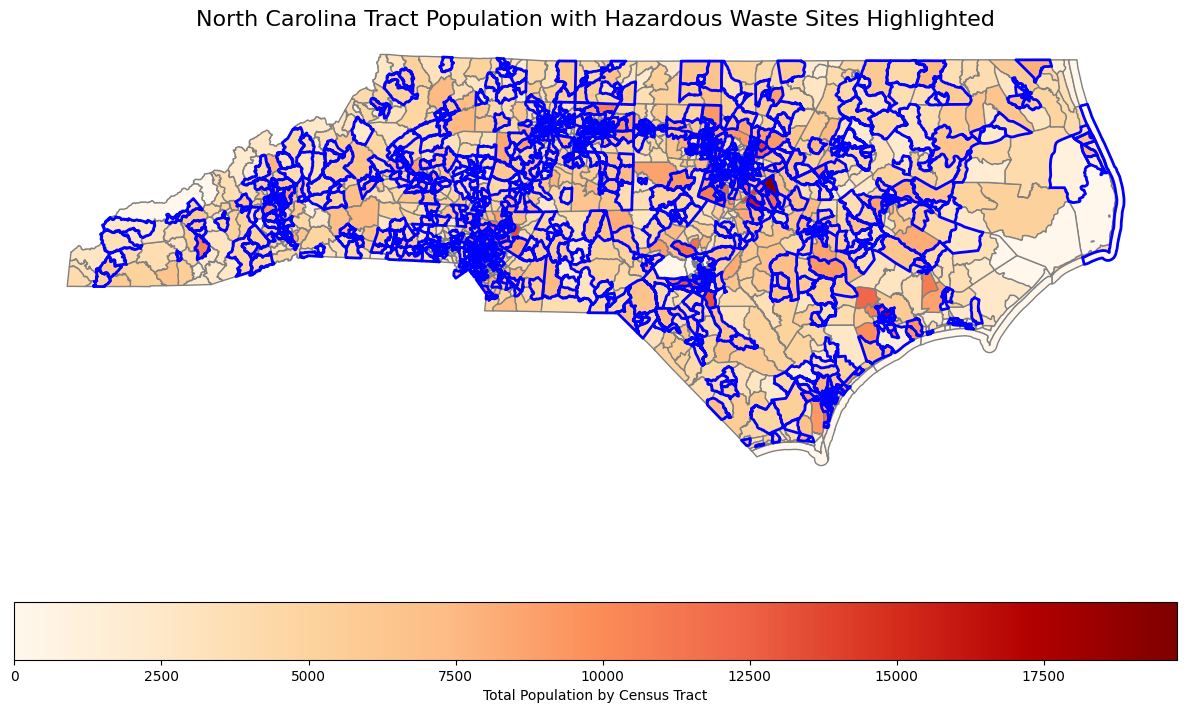



--------------- Done ---------------




In [35]:
all_code = all_operation_code_str + '\n' + solution.code_for_assembly

# display(Code(all_code, language='python'))

all_code = solution.execute_complete_program(code=all_code, try_cnt=10)